Importar librerías necesarias

In [1]:
# Importación de librerías
import pandas as pd
from pathlib import Path
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


1 - Cargar y preparar los datos

In [2]:
# 1. Detectar carpeta actual y raíz del proyecto
current_dir = Path(os.getcwd())
project_root = current_dir.parent.parent
data_path = project_root / "data" / "raw" / "heart-disease-dataset.csv"

# 2. Cargar CSV
heart = pd.read_csv(data_path)

# 3. Limpiar columnas no deseadas
heart.drop(columns=['exercise_angina', 'oldpeak', 'st_slope'], inplace=True)

heart.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,1.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0


| Variable                                                            | ¿Riesgo de Fuga? | Comentario                                                                                                             |
| ------------------------------------------------------------------- | ---------------- | ---------------------------------------------------------------------------------------------------------------------- |
| `age`, `sex`                                                        | ❌ No             | Datos demográficos seguros.                                                                                            |
| `chest_pain_type`                                                   | ⚠️ Bajo          | Síntoma subjetivo, pero válido clínicamente como predictor temprano.                                                   |
| `resting_bp_s`, `cholesterol`, `fasting_blood_sugar`, `resting_ecg` | ❌ No             | Datos de ingreso médico, seguros.                                                                                      |
| `max_heart_rate`                                                    | ⚠️ Posible       | Obtenido durante una prueba de esfuerzo, pero a veces se considera como parte de una evaluación inicial. Riesgo medio. |
| `exercise_angina`                                                   | ✅ Sí             | Derivado de una prueba de esfuerzo. Se hace típicamente después de sospechas clínicas.                                 |
| `oldpeak`                                                           | ✅ Sí             | Resultado de electrocardiograma bajo estrés físico (post-evaluación inicial).                                          |
| `st_slope`                                                          | ✅ Sí             | Derivado directo de `oldpeak`. Involucra interpretación de prueba de esfuerzo.                                         |


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   float64
 1   sex                  1190 non-null   float64
 2   chest_pain_type      1190 non-null   float64
 3   resting_bp_s         1190 non-null   float64
 4   cholesterol          1190 non-null   float64
 5   fasting_blood_sugar  1190 non-null   float64
 6   resting_ecg          1190 non-null   float64
 7   max_heart_rate       1190 non-null   float64
 8   target               1190 non-null   float64
dtypes: float64(9)
memory usage: 83.8 KB


2 - Preparación de datos Train y Test 

In [4]:
# Separar features y target
X = heart.drop('target', axis=1)
y = heart['target']

In [5]:
# Escalar datos y dividir en entrenamiento/test
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


3 – Definir modelos y GridSearch

In [6]:
# Definir modelos a comparar y sus grids de hiperparámetros
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.5, 1.0]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 150],
            "learning_rate": [0.1, 0.05],
            "max_depth": [3, 5]
        }
    }
}


4 – Ejecutar GridSearch y guardar resultados

In [7]:
# Entrenar y comparar modelos con GridSearchCV de forma robusta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

rows = []

for name, mp in models_params.items():
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    # Convertir temporalmente para la evaluación
    y_test_int = y_test.astype(int)
    y_pred_int = y_pred.astype(int)

    report = classification_report(y_test_int, y_pred_int, output_dict=True)

    # report = classification_report(y_test, y_pred, output_dict=True)

    # Print Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} → Matriz de confusión:")
    print(cm)

    # Acceder a métricas de la clase positiva (1), usando .get por seguridad
    class_1_metrics = report.get("1", {"precision": 0, "recall": 0, "f1-score": 0})
    
    rows.append({
        "Model": name,
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": report["accuracy"],
        "Precision": class_1_metrics["precision"],
        "Recall": class_1_metrics["recall"],
        "F1-Score": class_1_metrics["f1-score"],
        "Best Params": grid.best_params_
    })

# Crear DataFrame con resultados
results_df = pd.DataFrame(rows)

# Asegurarse de que exista la carpeta 'results'
output_path = project_root / "results"
output_path.mkdir(parents=True, exist_ok=True)

# Guardar resultados
results_df.to_csv(output_path / "model_comparison_results.csv", index=False)
print("Archivo guardado en: results/model_comparison_results.csv")


Random Forest → Matriz de confusión:
[[ 97  10]
 [ 15 116]]
AdaBoost → Matriz de confusión:
[[ 86  21]
 [ 22 109]]
Gradient Boosting → Matriz de confusión:
[[ 91  16]
 [ 15 116]]
Archivo guardado en: results/model_comparison_results.csv


In [8]:
print(results_df)

               Model   ROC AUC  Accuracy  Precision    Recall  F1-Score  \
0      Random Forest  0.951594  0.894958   0.920635  0.885496  0.902724   
1           AdaBoost  0.880467  0.819328   0.838462  0.832061  0.835249   
2  Gradient Boosting  0.925091  0.869748   0.878788  0.885496  0.882129   

                                         Best Params  
0  {'max_depth': None, 'min_samples_split': 2, 'n...  
1        {'learning_rate': 0.5, 'n_estimators': 100}  
2  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  


In [9]:
results_df

,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Random Forest,0.951594,0.894958,0.920635,0.885496,0.902724,"{'max_depth': None, 'min_samples_split': 2, 'n..."
1,AdaBoost,0.880467,0.819328,0.838462,0.832061,0.835249,"{'learning_rate': 0.5, 'n_estimators': 100}"
2,Gradient Boosting,0.925091,0.869748,0.878788,0.885496,0.882129,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


5 – Matriz de Confusión

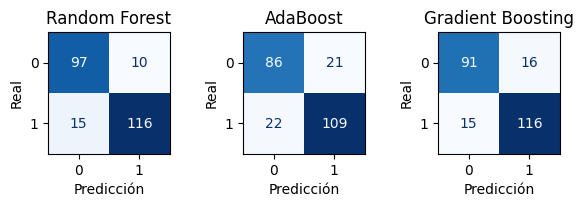

In [10]:
# Mostrar matrices de confusión para todos los modelos en una sola figura
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear figura con 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

for ax, (name, mp) in zip(axes, models_params.items()):
    model = mp["model"].set_params(**rows[[r["Model"] for r in rows].index(name)]["Best Params"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


|                      | **Predicho: 0 (Sano)** | **Predicho: 1 (Enfermo)** |
|----------------------|------------------------|----------------------------|
| **Real: 0 (Sano)**   | **TP (Verdaderos Negativos)** | **FP (Falsos Positivos)** |
| **Real: 1 (Enfermo)**| **FN (Falsos Negativos)**     | **TP (Verdaderos Positivos)** |

Visualización comparativa de métricas

In [11]:
# Seleccionar columnas relevantes
metrics_df = pd.DataFrame(rows)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.set_index('Model', inplace=True)

# Función para resaltar el valor máximo en cada columna
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkblue' if v else '' for v in is_max]

# Mostrar con estilos
styled_table = metrics_df.style.apply(highlight_max, axis=0).format("{:.3f}")
styled_table

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.895,0.921,0.885,0.903
AdaBoost,0.819,0.838,0.832,0.835
Gradient Boosting,0.870,0.879,0.885,0.882


In [12]:
# Análisis automático del mejor modelo basado en métricas clave
import pandas as pd

# Crear DataFrame con resultados
df_metrics = pd.DataFrame(rows)

# Evaluar por F1-Score como métrica global de equilibrio entre precisión y recall
best_model = df_metrics.loc[df_metrics['F1-Score'].idxmax()]

# Mostrar resumen claro
print("🔍 Evaluación comparativa de modelos:")
print(df_metrics[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']])
print("\nMejor modelo general:")

print(f"Modelo: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")
print(f"Precision: {best_model['Precision']:.3f}")
print(f"Recall: {best_model['Recall']:.3f}")
print(f"ROC AUC: {best_model['ROC AUC']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}")

# Justificación textual
print(f"\n✅ El modelo {best_model['Model']} ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto ({best_model['F1-Score']:.3f}),")
print(f"lo que indica un equilibrio sólido entre precisión ({best_model['Precision']:.3f}) y recall ({best_model['Recall']:.3f}).")
print(f"También destaca con un ROC AUC de {best_model['ROC AUC']:.3f}, lo que sugiere una excelente capacidad de discriminación.")


🔍 Evaluación comparativa de modelos:
               Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0      Random Forest  0.894958   0.920635  0.885496  0.902724  0.951594
1           AdaBoost  0.819328   0.838462  0.832061  0.835249  0.880467
2  Gradient Boosting  0.869748   0.878788  0.885496  0.882129  0.925091

Mejor modelo general:
Modelo: Random Forest
F1-Score: 0.903
Precision: 0.921
Recall: 0.885
ROC AUC: 0.952
Accuracy: 0.895

✅ El modelo Random Forest ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto (0.903),
lo que indica un equilibrio sólido entre precisión (0.921) y recall (0.885).
También destaca con un ROC AUC de 0.952, lo que sugiere una excelente capacidad de discriminación.


In [13]:
# Expandir el ancho de columnas en la salida de pandas
pd.set_option('display.max_colwidth', None)

# Mostrar solo el Random Forest
results_df[results_df['Model'] == 'Random Forest']


,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Random Forest,0.951594,0.894958,0.920635,0.885496,0.902724,"{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}"


Importancia de las características del mejor modelo (Random Forest)

📊 Importancia de las características:
max_heart_rate: 0.2114
chest_pain_type: 0.2085
cholesterol: 0.1723
age: 0.1665
resting_bp_s: 0.1215
sex: 0.0548
resting_ecg: 0.0357
fasting_blood_sugar: 0.0293


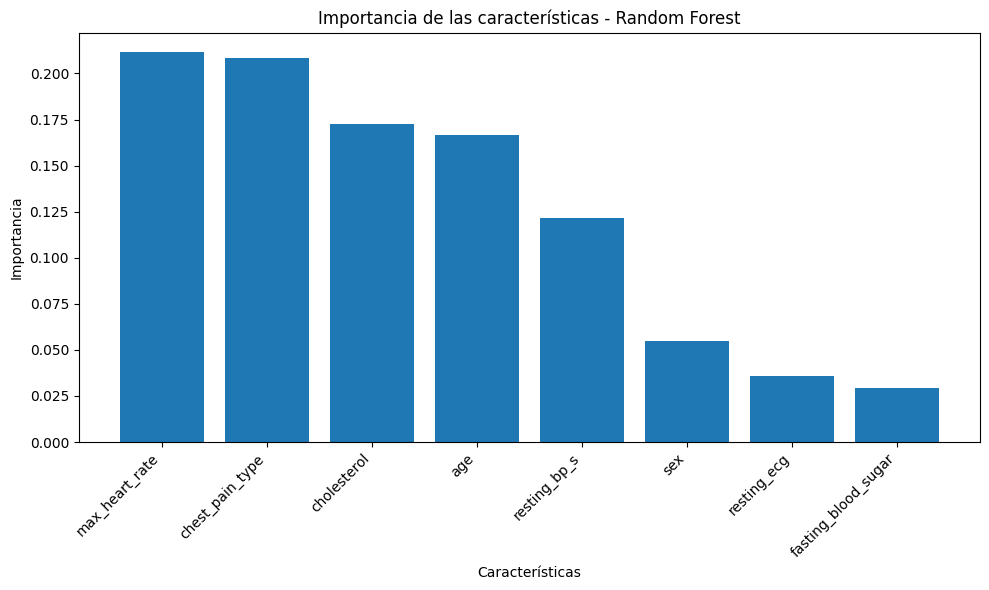

In [14]:
# 🧠 Mostrar la importancia de las características del modelo Random Forest
import matplotlib.pyplot as plt
import numpy as np

# Reentrenar el mejor modelo con todos los datos de entrenamiento
from sklearn.ensemble import RandomForestClassifier

# Usar los mejores parámetros encontrados
rf_params = results_df[results_df["Model"] == "Random Forest"]["Best Params"].values[0]
rf_model = RandomForestClassifier(**rf_params, random_state=42)
rf_model.fit(X_train, y_train)

# Obtener importancia de características
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Mostrar ordenado en consola
print("📊 Importancia de las características:")
for i in indices:
    print(f"{features[i]}: {importances[i]:.4f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características - Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=45, ha='right')
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()


_

Parte 1: Evaluar el rendimiento del modelo por sexo

Evaluar métricas por subgrupo (sex)

In [15]:
# Separa X y y:
X = heart.drop(columns=['target'])
y = heart['target']

# Guardar la columna 'sex' antes de escalar, para luego análisis por grupo
sex_raw = X['sex']


In [16]:
# Paso 1 - train_test_split, añade esto para dividir también sex_raw:
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X_scaled, y, sex_raw, test_size=0.2, random_state=42
)

In [17]:
# Paso 2 - Entrenar el modelo con los mejores parámetros encontrados

from sklearn.ensemble import RandomForestClassifier

# Extraer los mejores parámetros del Random Forest
rf_params = results_df[results_df["Model"] == "Random Forest"]["Best Params"].values[0]

# Crear y entrenar el modelo
rf_model = RandomForestClassifier(**rf_params, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [18]:
# Paso 3 – Predecir sobre X_test
y_pred = rf_model.predict(X_test)


In [19]:
# Paso 4 – Crear máscaras por sexo y evaluar
# Crear máscaras
mask_male = sex_test == 1
mask_female = sex_test == 0

# Evaluar por sexo
for label, mask in [("Hombres (1)", mask_male), ("Mujeres (0)", mask_female)]:
    print(f"\n📋 Resultados para {label}:")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test[mask], y_pred[mask]))
    print("Reporte de clasificación:")
    print(classification_report(y_test[mask], y_pred[mask]))



📋 Resultados para Hombres (1):
Matriz de confusión:
[[ 58  10]
 [ 13 108]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83        68
         1.0       0.92      0.89      0.90       121

    accuracy                           0.88       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.88      0.88      0.88       189


📋 Resultados para Mujeres (0):
Matriz de confusión:
[[39  0]
 [ 2  8]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        39
         1.0       1.00      0.80      0.89        10

    accuracy                           0.96        49
   macro avg       0.98      0.90      0.93        49
weighted avg       0.96      0.96      0.96        49



[[TN FP]

[FN TP]]

_

### NUEVO ENTRENAMIENTO CON NUEVO DATASET BALANCEADO POR SEXO 

In [ ]:
# Path para cargar el dataset de mujeres
data_path = project_root / "data" / "synthetic" / "heart_females_synthetic.csv"

synthetic = pd.read_csv(data_path)

synthetic.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target
0,35,0.0,3.0,100,40,0.0,0.0,159,1.0
1,53,0.0,3.0,130,344,0.0,0.0,150,0.0
2,35,0.0,4.0,180,409,0.0,2.0,150,0.0
3,58,0.0,2.0,135,243,0.0,0.0,182,1.0
4,35,0.0,3.0,100,344,0.0,0.0,157,0.0


In [29]:
# Verificamos que sex = 0 en el sintético
print("Valores únicos en 'sex' (sintético):", synthetic['sex'].unique())

Valores únicos en 'sex' (sintético): [0.]


In [25]:
synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  500 non-null    int64  
 1   sex                  500 non-null    float64
 2   chest_pain_type      500 non-null    float64
 3   resting_bp_s         500 non-null    int64  
 4   cholesterol          500 non-null    int64  
 5   fasting_blood_sugar  500 non-null    float64
 6   resting_ecg          500 non-null    float64
 7   max_heart_rate       500 non-null    int64  
 8   target               500 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 35.3 KB


In [26]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   float64
 1   sex                  1190 non-null   float64
 2   chest_pain_type      1190 non-null   float64
 3   resting_bp_s         1190 non-null   float64
 4   cholesterol          1190 non-null   float64
 5   fasting_blood_sugar  1190 non-null   float64
 6   resting_ecg          1190 non-null   float64
 7   max_heart_rate       1190 non-null   float64
 8   target               1190 non-null   float64
dtypes: float64(9)
memory usage: 83.8 KB


In [27]:
# Convertir todas las columnas a float64 en el dataset sintético
synthetic = synthetic.astype('float64')

In [28]:
synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  500 non-null    float64
 1   sex                  500 non-null    float64
 2   chest_pain_type      500 non-null    float64
 3   resting_bp_s         500 non-null    float64
 4   cholesterol          500 non-null    float64
 5   fasting_blood_sugar  500 non-null    float64
 6   resting_ecg          500 non-null    float64
 7   max_heart_rate       500 non-null    float64
 8   target               500 non-null    float64
dtypes: float64(9)
memory usage: 35.3 KB


In [30]:
# Concatenar original + sintético
heart_augmented = pd.concat([heart, synthetic], ignore_index=True)

print("\n✅ Dataset combinado:")
print("Original:", heart.shape)
print("Sintético:", synthetic.shape)
print("Total:", heart_augmented.shape)


✅ Dataset combinado:
Original: (1190, 9)
Sintético: (500, 9)
Total: (1690, 9)


### Reentrenar el modelo y comparar resultados por sexo

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separar variables
X = heart_augmented.drop(columns=['target'])
y = heart_augmented['target']
sex_raw = X['sex']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División del dataset (incluyendo sex)
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X_scaled, y, sex_raw, test_size=0.2, random_state=42
)

# Entrenar modelo con mejores parámetros anteriores
rf_model = RandomForestClassifier(**rf_params, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [34]:
# Predicciones
y_pred = rf_model.predict(X_test)

#### Evaluación por sexo tras el aumento de datos

In [38]:
# Evaluar por grupo (mujeres y hombres)
mask_male = sex_test == 1
mask_female = sex_test == 0

for label, mask in [("Hombres (1)", mask_male), ("Mujeres (0)", mask_female)]:
    print(f"\n📋 Resultados para {label}:")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test[mask], y_pred[mask]))
    print("Reporte de clasificación:")
    print(classification_report(y_test[mask], y_pred[mask]))



📋 Resultados para Hombres (1):
Matriz de confusión:
[[ 55  10]
 [ 18 108]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80        65
         1.0       0.92      0.86      0.89       126

    accuracy                           0.85       191
   macro avg       0.83      0.85      0.84       191
weighted avg       0.86      0.85      0.86       191


📋 Resultados para Mujeres (0):
Matriz de confusión:
[[102   7]
 [ 24  14]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       109
         1.0       0.67      0.37      0.47        38

    accuracy                           0.79       147
   macro avg       0.74      0.65      0.67       147
weighted avg       0.77      0.79      0.77       147



|                      | **Predicho: 0 (Sano)** | **Predicho: 1 (Enfermo)** |
|----------------------|------------------------|----------------------------|
| **Real: 0 (Sano)**   | **TP (Verdaderos Negativos)** | **FP (Falsos Positivos)** |
| **Real: 1 (Enfermo)**| **FN (Falsos Negativos)**     | **TP (Verdaderos Positivos)** |

_

Analizar qué falló en las predicciones

* Ver ejemplos de falsos negativos (mujeres con target=1 mal predichas).

* Ver su chest_pain_type, cholesterol, etc.

In [39]:
# Resultados anteriores (modelo sin sintéticos)
metrics_before = {
    "Hombres": {"precision": 0.92, "recall": 0.89, "f1": 0.90},
    "Mujeres": {"precision": 1.00, "recall": 0.80, "f1": 0.89}
}

# Resultados actuales (modelo con sintéticos)
metrics_after = {
    "Hombres": {"precision": 0.92, "recall": 0.86, "f1": 0.89},
    "Mujeres": {"precision": 0.67, "recall": 0.37, "f1": 0.47}
}


Ver ejemplos fallidos (falsos negativos)

In [42]:
# X_test, y_test y y_pred ya están disponibles
import pandas as pd

# Recuperamos las predicciones que fallan: mujeres con target=1 pero predice 0
mask_fn = (sex_test == 0) & (y_test == 1) & (y_pred == 0)
false_negatives = pd.DataFrame(X_test[mask_fn], columns=X.columns)

# Añadir target y predicho para analizar
false_negatives["target_real"] = y_test[mask_fn].values
false_negatives["predicho"] = y_pred[mask_fn]

false_negatives.head()


,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target_real,predicho
0,0.009827,-1.078838,-1.165988,0.619220,0.144356,-0.470211,1.410254,-0.083059,1.0,0.0
1,-2.017785,-1.078838,0.890922,-1.507054,0.251782,-0.470211,-0.844551,0.310024,1.0,0.0
2,-1.535020,-1.078838,-1.165988,-1.507054,0.544759,-0.470211,-0.844551,1.567890,1.0,0.0
3,0.396038,-1.078838,-1.165988,0.043354,0.222484,-0.470211,-0.844551,1.567890,1.0,0.0
4,0.782250,-1.078838,-0.137533,-0.443917,-0.216983,-0.470211,1.410254,1.489273,1.0,0.0


In [44]:
print(false_negatives)

         age       sex  chest_pain_type  resting_bp_s  cholesterol  \
0   0.009827 -1.078838        -1.165988      0.619220     0.144356   
1  -2.017785 -1.078838         0.890922     -1.507054     0.251782   
2  -1.535020 -1.078838        -1.165988     -1.507054     0.544759   
3   0.396038 -1.078838        -1.165988      0.043354     0.222484   
4   0.782250 -1.078838        -0.137533     -0.443917    -0.216983   
5   0.685697 -1.078838         0.890922     -0.178133     0.134591   
6   0.878803 -1.078838         0.890922     -0.443917    -0.226748   
7   0.975356 -1.078838         0.890922      2.922683    -2.150634   
8  -0.569491 -1.078838        -2.194443     -1.507054     1.335798   
9   0.299485 -1.078838        -0.137533     -0.621107     1.843626   
10  1.651226 -1.078838         0.890922      1.150788    -0.148621   
11 -0.183279 -1.078838        -1.165988      2.036735    -1.515850   
12 -0.279832 -1.078838        -0.137533     -0.178133    -0.060728   
13 -0.666044 -1.0788

In [45]:
false_negatives[["chest_pain_type", "cholesterol", "max_heart_rate", "fasting_blood_sugar"]].describe()


,chest_pain_type,cholesterol,max_heart_rate,fasting_blood_sugar
count,24.000000,24.000000,24.000000,24.000000
mean,-0.308942,0.199697,0.318213,-0.362006
std,1.035881,0.927977,0.919890,0.530093
min,-2.194443,-2.150634,-1.734008,-0.470211
25%,-1.165988,-0.158387,-0.083059,-0.470211
50%,-0.137533,0.202952,0.310024,-0.470211
75%,0.890922,0.574057,1.096190,-0.470211
max,0.890922,1.843626,1.567890,2.126705
